In [ ]:
#from google.colab import drive
#drive.flush_and_unmount()


In [ ]:
from google.colab import drive
import os
import time

# Check if the drive is already mounted
try:
    # List directory content to see if the drive is mounted
    os.listdir('/content/drive')
    print('Drive is already mounted, skipping mount.')
except FileNotFoundError:
    # Drive not mounted, proceed with mounting
    drive.mount('/content/drive')
    print('Drive mounted.')

# Access your project directory
mount_path = '/content/drive/MyDrive/Colab Notebooks/'

# Create the necessary directories (only if they don't exist)
os.makedirs(mount_path, exist_ok=True)

Mounted at /content/drive
Drive mounted.


In [ ]:
!pwd
!ls -la

/content
total 20
drwxr-xr-x 1 root root 4096 Aug 13 15:32 .
drwxr-xr-x 1 root root 4096 Aug 13 15:25 ..
drwxr-xr-x 4 root root 4096 Aug 11 13:35 .config
drwx------ 5 root root 4096 Aug 13 15:32 drive
drwxr-xr-x 1 root root 4096 Aug 11 13:36 sample_data


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/MVTech
!ls -la


/content/drive/MyDrive/Colab Notebooks/MVTech
total 102
drwx------ 2 root root  4096 Jun  8 18:23 mvtec_anomaly_detection
-rw------- 1 root root 99835 Jun 17 14:26 MVtechV1.ipynb


In [ ]:
!pip install  torch torchvision torchaudio
!pip install  scikit-learn pandas seaborn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torch.utils.data import Dataset, ConcatDataset, random_split
from torchvision.io import read_image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, accuracy_score
from tqdm.notebook import trange, tqdm # Use tqdm.notebook for Colab compatibility and import tqdm specifically
import numpy as np
import seaborn as sns
import pandas as pd
import json
from time import time
from collections import Counter
from PIL import Image
import os
import tarfile

from tqdm import tqdm

from torchvision.transforms.functional import resize, to_tensor, normalize, InterpolationMode


from torchvision.transforms import Normalize, Compose
#from torchvision.transforms import functional as F  # Main functional interface



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────--------------------
# Global Configuration. Code jdcorrea astropema.com obaozai@gmail.com oba@astropema.com May 24, 2025
# ──────────────────────────────────────────────────────────────────────────────--------------------
#There are 465 unique combinations of (dataset category, set of models to compare) that you could
#potentially configure and run with your current code structure, based on the commented-out options
#and the defined models.

#There are 15 distinct categories in this list. If you were to select one category at a time, there are 15 choices for the dataset.
#Total Combinations = (Number of Categories) * (Number of Non-Empty Subsets of Models) Total Combinations = 15 * 31 = 465

# SELECT CATEGORY TO TEST FROM THIS LIST.
#DATASET_CATEGORY = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut", "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper"]
DATASET_CATEGORY = 'metal_nut' # Set your desired dataset category here from top choices.

# SELECT MODELS_TO_COMPARE TO TEST FROM THIS LIST.
#MODELS_TO_COMPARE = ["basic", "deeper", "resnet", "efficient", "attention"] <- you can compare more than one at a time.
MODELS_TO_COMPARE = ["resnet"]

#Set Directories and Path
RESULTS_DIR = "/content/model_comparison_results" # Save results to /content which is faster
# Update BASE_PATH to point to the extracted dataset directory
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/MVTech/mvtec_anomaly_detection'


EPOCHS = 100
BATCH_SIZE = 32  # Default Batch Size
ATTENTION_BATCH_SIZE = 8 # Smaller batch size for attention model (adjust based on GPU memory)
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5 # Added weight decay for regularization
EARLY_STOPPING_PATIENCE = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Untar MVTec Anomaly Detection archive if not present.
# ──────────────────────────────────────────────────────────────────────────────


# Configuration - make these variables easily changeable

archive_name = 'mvtec_anomaly_detection.tar.xz'

# Use the mount_path variable
archive_path = os.path.join(mount_path, 'MVTech', archive_name)
extract_path = os.path.join(mount_path, 'MVTech', 'mvtec_anomaly_detection')

# Only extract if not already extracted
if not os.path.isdir(extract_path):
    print(f'Extracting {archive_path}...')
    try:
        with tarfile.open(archive_path, 'r:xz') as tar:
            # Use tqdm for extraction progress
            tar.extractall(path=extract_path)
            print(f'Extracted to {extract_path}')
    except FileNotFoundError:
        print(f"Error: Archive not found at {archive_path}. Please check the path and ensure the file exists.")
        raise FileNotFoundError(f"Archive not found at {archive_path}")
    except tarfile.ReadError:
         print(f"Error: Could not read archive at {archive_path}. It might be corrupted or not a valid tar.xz file.")
         raise tarfile.ReadError(f"Could not read archive at {archive_path}")
else:
    print(f'Already extracted at: {extract_path}')

# Verify the specific dataset exists
dataset_path = os.path.join(extract_path, DATASET_CATEGORY)
if not os.path.isdir(dataset_path):
    raise FileNotFoundError(f"Dataset '{DATASET_NAME}' not found in {extract_path}. Available datasets: {os.listdir(extract_path)}")

print(f"Using dataset: {DATASET_CATEGORY}")
print(f"Dataset path: {dataset_path}")

Already extracted at: /content/drive/MyDrive/Colab Notebooks/MVTech/mvtec_anomaly_detection
Using dataset: metal_nut
Dataset path: /content/drive/MyDrive/Colab Notebooks/MVTech/mvtec_anomaly_detection/metal_nut


In [ ]:
'''
import torch
from torchvision.transforms.functional import resize, to_tensor, normalize, InterpolationMode
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
'''

# 1) Define your ConvAutoencoder class right here:
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # … your encoder/decoder layers …
    def forward(self, x):
        # … forward logic …
        return recon

# 2) Define the threshold helper right here:
def estimate_threshold(scores, method="p_quantile", p=0.99, k=3, max_area_frac=0.001):
    vals = np.concatenate([s.flatten() for s in scores])
    if method == "max":
        t = vals.max()
    elif method == "p_quantile":
        t = np.quantile(vals, p)
    elif method == "k_sigma":
        t = vals.mean() + k * vals.std()
    else:
        raise ValueError(f"Unknown method {method}")
    binary = [s > t for s in scores]
    # max_area logic omitted for brevity
    return t, binary


In [ ]:
!pwd
!ls -la

/content/drive/MyDrive/Colab Notebooks/MVTech
total 102
drwx------ 3 root root  4096 Jun  8 18:23 mvtec_anomaly_detection
-rw------- 1 root root 99835 Jun 17 14:26 MVtechV1.ipynb


In [ ]:
#Load Training and Testing Good

TRAIN_DIR = os.path.join(BASE_PATH, DATASET_CATEGORY, 'train')
TEST_DIR  = os.path.join(BASE_PATH, DATASET_CATEGORY, 'test')

VALID_EXTS = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.ppm', '.pgm', '.webp')

# 1) Inspect train/test directories
for split_name, split_dir in [('TRAIN', TRAIN_DIR), ('TEST', TEST_DIR)]:
    print(f"\n🔍 {split_name} directory: {split_dir}")
    if not os.path.isdir(split_dir):
        print(f"   ✗ Directory not found: {split_dir}")
        continue
    classes = sorted(d for d in os.listdir(split_dir)
                     if os.path.isdir(os.path.join(split_dir, d)))
    total, valid = 0, 0
    for cls in classes:
        imgs = os.listdir(os.path.join(split_dir, cls))
        total += len(imgs)
        valid += sum(1 for f in imgs if f.lower().endswith(VALID_EXTS))
    print(f"   ✓ Classes: {classes}")
    print(f"     total files = {total}, valid images = {valid}")

# Import the necessary function before using it
from torchvision.transforms.functional import resize, to_tensor, normalize, InterpolationMode

# 2) Define verbose transforms
def t_resize(img):
    orig = img.size
    # Now 'resize' is defined because we imported it
    out = resize(img, [128,128],
                 interpolation=InterpolationMode.BILINEAR, antialias=True)
    print(f"[T] resize: {orig} → {out.size}")
    return out

def t_to_tensor(img):
    # Now 'ToTensor' is defined because we imported it
    t = to_tensor(img)
    print(f"[T] ToTensor → {tuple(t.shape)}")
    return t

def t_norm(t):
    # Now 'Normalize' is defined because we imported it
    out = normalize(t, mean=[0.5]*3, std=[0.5]*3)
    print(f"[T] normalize mean={out.mean():.3f}, std={out.std():.3f}")
    return out

# Need to explicitly import Compose as well if not done globally already
from torchvision.transforms import Compose

transform = Compose([t_resize, t_to_tensor, t_norm])

# 3) Build ImageFolder + DataLoader for TRAIN split
print(f"\n▶ Initializing DataLoader for {DATASET_CATEGORY}/train") # Use DATASET_CATEGORY
train_ds = ImageFolder(root=TRAIN_DIR, transform=transform)
print(f"   Found {len(train_ds)} images in {len(train_ds.classes)} classes: {train_ds.classes}")

if len(train_ds) > 0:
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    imgs, labels = next(iter(train_loader))
    print(f"   ▶ Batch: imgs {tuple(imgs.shape)}, labels {labels.tolist()}")
else:
    print("   ‼ No training images found; check your TRAIN_DIR path and contents.")


🔍 TRAIN directory: /content/drive/MyDrive/Colab Notebooks/MVTech/mvtec_anomaly_detection/metal_nut/train
   ✓ Classes: ['good']
     total files = 220, valid images = 220

🔍 TEST directory: /content/drive/MyDrive/Colab Notebooks/MVTech/mvtec_anomaly_detection/metal_nut/test
   ✓ Classes: ['bent', 'color', 'flip', 'good', 'scratch']
     total files = 115, valid images = 115

▶ Initializing DataLoader for metal_nut/train
   Found 220 images in 1 classes: ['good']
[T] resize: (700, 700) → (128, 128)
[T] ToTensor → (3, 128, 128)
[T] normalize mean=-0.493, std=0.368
[T] resize: (700, 700) → (128, 128)
[T] ToTensor → (3, 128, 128)
[T] normalize mean=-0.485, std=0.392
[T] resize: (700, 700) → (128, 128)
[T] ToTensor → (3, 128, 128)
[T] normalize mean=-0.507, std=0.345
[T] resize: (700, 700) → (128, 128)
[T] ToTensor → (3, 128, 128)
[T] normalize mean=-0.587, std=0.271
   ▶ Batch: imgs (4, 3, 128, 128), labels [0, 0, 0, 0]


In [ ]:
# Data Loading with Augmentation using functional transforms

from torchvision.transforms import Normalize, Compose
from torchvision.transforms import functional as F  # Main functional interface
from torchvision.transforms.functional import InterpolationMode
import torch

# Enhanced Data Loading with Augmentation using functional transforms
train_transform = Compose([
    # Convert PIL Image to tensor first if needed (handled by dataset)
    lambda img_tensor: F.resize(img_tensor, [128, 128], interpolation=InterpolationMode.BILINEAR, antialias=True),
    lambda img_tensor: F.hflip(img_tensor) if torch.rand(1) < 0.5 else img_tensor,
    lambda img_tensor: F.vflip(img_tensor) if torch.rand(1) < 0.5 else img_tensor,

    # rotation:
    # lambda img_tensor: F.rotate(img_tensor, angle=float(torch.empty(1).uniform_(-15, 15).item())),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Corrected Normalize
])

test_transform = Compose([
    lambda img_tensor: F.resize(img_tensor, [128, 128], interpolation=InterpolationMode.BILINEAR, antialias=True),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Corrected Normalize
])

In [ ]:
class SimpleLabelImageSet(Dataset):
    def __init__(self, folder, label, transform=None):
        # Check if the folder exists
        if not os.path.isdir(folder):
            raise FileNotFoundError(f"Dataset folder not found: {folder}")

        self.paths = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')])
        if not self.paths:
             print(f"Warning: No PNG images found in {folder}")

        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # read_image reads in CHW format and uint8. Scale to 0-1 float.
        # This already returns a torch.Tensor
        img = read_image(self.paths[idx]).float() / 255.0

        # Handle grayscale images which have 1 channel, but models expect 3
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1) # Repeat grayscale channel 3 times

        # Apply tensor-based transforms directly
        if self.transform:
            img = self.transform(img)

        label = self.label
        return img, label, self.paths[idx] # Also return path for visualization

In [ ]:
# Define base paths - add these at the top of your code
DATASET_ROOT = os.path.join(mount_path, 'MVTech/mvtec_anomaly_detection')  # Your extracted dataset path

# Define train and test paths
# Use the correctly defined global variable DATASET_CATEGORY
TRAIN_PATH = os.path.join(DATASET_ROOT, DATASET_CATEGORY, 'train')
TEST_PATH = os.path.join(DATASET_ROOT, DATASET_CATEGORY, 'test')


# Now the rest of your code can use these paths
good_train_path = os.path.join(TRAIN_PATH, "good")

# In MVTec, defect images are only in the test set.
# To create a mixed train set, we use the 'good' images from train
# and the 'defect' images from test for training/validation.
defect_types = [d for d in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, d)) and d != 'good']

# Calculate class weights more precisely from the actual train/validation split
# (using all good + all defects for the full dataset before splitting)
good_count = len(os.listdir(good_train_path)) if os.path.isdir(good_train_path) else 0
defect_count = 0
for d in defect_types:
    defect_folder = os.path.join(TEST_PATH, d)
    if os.path.isdir(defect_folder):
        defect_count += len(os.listdir(defect_folder))

total_samples = good_count + defect_count

if total_samples == 0:
    print(f"Error: No images found for category '{MVTEC_CATEGORY}'. Please check the dataset path and category name.")
    raise FileNotFoundError(f"No images found for category '{MVTEC_CATEGORY}'")
else:
    print(f"Found {good_count} good samples and {defect_count} defect samples")

Found 220 good samples and 93 defect samples


In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2), # 128 -> 64
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2), # 64 -> 32
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2), # 32 -> 16
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x): return self.net(x)

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2), # 128 -> 64
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 64 -> 32
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # 32 -> 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # 128 * 16 * 16 = 32768
            nn.Linear(128 * 16 * 16, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity # Add shortcut
        out = self.relu(out) # Apply ReLU after addition
        return out

In [ ]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial downsampling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) # 128 -> 64
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 64 -> 32

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2) # 32 -> 32
        self.layer2 = self._make_layer(64, 128, 2, stride=2) # 32 -> 16
        self.layer3 = self._make_layer(128, 256, 2, stride=2) # 16 -> 8

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 8 -> 1
        self.fc = nn.Linear(256, 2)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_residual = stride == 1 and in_channels == out_channels
        # Only apply depthwise convolution if hidden_dim > 0 (i.e., expand_ratio > 0)
        # Also, only apply point-wise conv (second half) if out_channels > 0
        self.conv = nn.Sequential()

        # Expansion phase (if expand_ratio is not 1)
        if expand_ratio != 1:
            self.conv.add_module("exp_conv", nn.Conv2d(in_channels, hidden_dim, 1, bias=False))
            self.conv.add_module("exp_bn", nn.BatchNorm2d(hidden_dim))
            self.conv.add_module("exp_relu", nn.ReLU6(inplace=True))

        # Depthwise convolution phase
        self.conv.add_module("dep_conv", nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False))
        self.conv.add_module("dep_bn", nn.BatchNorm2d(hidden_dim))
        self.conv.add_module("dep_relu", nn.ReLU6(inplace=True))

        # Projection phase (pointwise convolution)
        self.conv.add_module("point_conv", nn.Conv2d(hidden_dim, out_channels, 1, bias=False))
        self.conv.add_module("point_bn", nn.BatchNorm2d(out_channels))

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        return self.conv(x)


In [ ]:
class EfficientNetLike(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            # Initial convolution
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False), # 128 -> 64
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # MBConv blocks
            MBConv(16, 24, expand_ratio=3, stride=1), # 64 -> 64
            MBConv(24, 24, expand_ratio=3, stride=1), # 64 -> 64

            MBConv(24, 40, expand_ratio=3, stride=2), # 64 -> 32
            MBConv(40, 40, expand_ratio=3, stride=1), # 32 -> 32

            MBConv(40, 80, expand_ratio=6, stride=2), # 32 -> 16
            MBConv(80, 80, expand_ratio=6, stride=1), # 16 -> 16
            MBConv(80, 80, expand_ratio=6, stride=1), # 16 -> 16

            MBConv(80, 112, expand_ratio=6, stride=1), # 16 -> 16
            MBConv(112, 112, expand_ratio=6, stride=1), # 16 -> 16
            MBConv(112, 112, expand_ratio=6, stride=1), # 16 -> 16

            MBConv(112, 192, expand_ratio=6, stride=2), # 16 -> 8
            MBConv(192, 192, expand_ratio=6, stride=1), # 8 -> 8
            MBConv(192, 192, expand_ratio=6, stride=1), # 8 -> 8
            MBConv(192, 192, expand_ratio=6, stride=1), # 8 -> 8

            # Final convolution
            nn.Conv2d(192, 320, kernel_size=1, bias=False), # 8 -> 8
            nn.BatchNorm2d(320),
            nn.ReLU6(inplace=True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1) # 8 -> 1
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(320, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, channel):
        super().__init__()
        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # A shared MLP to process the pooled features
        # We use a bottleneck design (reduction_ratio = 16 is common)
        reduction_ratio = 16
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_ratio, channel, bias=False),
            nn.Sigmoid() # Sigmoid to get attention weights between 0 and 1
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze operation (Global Average Pooling)
        y = self.avg_pool(x).view(b, c)
        # Excitation operation (MLP)
        y = self.fc(y).view(b, c, 1, 1)
        # Scale the input features by the attention weights
        return x * y.expand_as(x)

In [ ]:
class AttentionCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2), # 128 -> 64
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2), # 64 -> 32
            # Add an AttentionBlock here. The input channels should match the output channels of the previous layer.
            # In this case, it's 64.
            AttentionBlock(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2), # 32 -> 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class ResNet18Conv(nn.Module):
    """
    Feature‐extraction backbone using the convolutional layers of ResNet-18.
    Strips off the avgpool+fc head so you get a H×W×512 feature map.
    """
    def __init__(self, pretrained: bool = True):
        super().__init__()
        # Load a ResNet-18 and keep only the conv layers + residual blocks
        backbone = resnet18(pretrained=pretrained)
        self.features = nn.Sequential(
            backbone.conv1,   # 64, /2
            backbone.bn1,
            backbone.relu,
            backbone.maxpool, # /2
            backbone.layer1,  # size stays
            backbone.layer2,  # /2
            backbone.layer3,  # /2
            backbone.layer4,  # /2
        )
        # Optional: keep avgpool if you want a 512‐d embedding vector:
        self.avgpool = backbone.avgpool

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, 3, H, W) input images
        Returns:
            feats: if you want a feature map -> (B, 512, H′, W′)
                   if you use avgpool -> (B, 512, 1, 1)
        """
        feats = self.features(x)
        # Uncomment the next two lines if you want a global 512-d vector
        # feats = self.avgpool(feats)       # -> (B, 512, 1, 1)
        # feats = torch.flatten(feats, 1)   # -> (B, 512)
        return feats

# Example usage:
# conv_backbone = ResNet18Conv(pretrained=True).to(DEVICE)
# feature_map = conv_backbone(torch.randn(8, 3, 128, 128).to(DEVICE))
# print(feature_map.shape)  # e.g. (8, 512, 4, 4) for input 128×128


In [ ]:
# Update the MODELS dictionary after defining the AttentionCNN class
MODELS = {
    "basic": BasicCNN,
    "deeper": DeeperCNN,
    "resnet": ResNetLike,
    "efficient": EfficientNetLike,
    "resnet18":   ResNet18Conv,
    "attention": AttentionCNN
}

In [ ]:
# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, epochs, patience, checkpoint_path):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'time_per_epoch': []}

    # Use tqdm for epoch progress bar
    epoch_iterator = trange(epochs, desc="Epochs")

    for epoch in epoch_iterator:
        start_time = time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm for batch progress bar
        batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False)

        for inputs, labels, _ in batch_iterator: # Added _ to ignore paths
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update batch progress bar
            batch_iterator.set_postfix(loss=loss.item())


        epoch_time = time() - start_time
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_acc))
        history['time_per_epoch'].append(float(epoch_time))

        val_loss, val_acc = evaluate_model(model, val_loader, loss_fn, device)
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))

        # Update epoch progress bar description
        epoch_iterator.set_postfix(train_loss=f"{train_loss:.4f}", train_acc=f"{train_acc:.2f}%", val_loss=f"{val_loss:.4f}", val_acc=f"{val_acc:.2f}%", epoch_time=f"{epoch_time:.2f}s")


        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save checkpoint
            torch.save(model.state_dict(), checkpoint_path)
            # print(f"Validation loss improved. Model saved at {checkpoint_path}") # Removed print to avoid spamming progress bar
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs") # Added newline to appear after progress bar
                break

    return history

In [ ]:
def evaluate_model(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # Use tqdm for evaluation progress bar
        eval_iterator = tqdm(loader, desc="Evaluating", leave=False)
        for inputs, labels, _ in eval_iterator: # Added _ to ignore paths
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update evaluation progress bar
            eval_iterator.set_postfix(loss=loss.item())


    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return float(avg_loss), float(accuracy)

In [ ]:
def compute_metrics(y_true, y_pred, y_prob):
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Handle cases where one class has 0 predictions
    # Ensure precision, recall, f1 are computed correctly with zero_division=0
    metrics = {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
    }

    # ROC AUC and Average Precision require at least one sample of each class.
    # Check class counts in y_true and y_pred before computing.
    true_class_counts = Counter(y_true)
    if len(true_class_counts) < 2:
        metrics['roc_auc'] = None # Cannot compute if only one class present in true labels
        metrics['average_precision'] = None # Cannot compute if only one class present in true labels
        fpr = [0.0, 1.0] # Default ROC curve (for plotting even if AUC is None)
        tpr = [0.0, 1.0]
        precision = [1.0, 0.0] # Default PR curve
        recall = [0.0, 1.0]
    else:
         # Ensure y_prob corresponds to the positive class (label 1)
        metrics['roc_auc'] = float(roc_auc_score(y_true, y_prob))
        metrics['average_precision'] = float(average_precision_score(y_true, y_prob))
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        precision, recall, _ = precision_recall_curve(y_true, y_prob)


    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_true, y_pred)
    metrics['confusion_matrix'] = cm.tolist() # Convert numpy array to list for JSON

    report_dict = classification_report(y_true, y_pred,
        target_names=['good', 'defect'],
        output_dict=True,
        zero_division=0)

    # Convert numpy types within the report dictionary to native Python types
    # This is necessary because output_dict=True returns numpy types which are not JSON serializable
    metrics['classification_report'] = json.loads(json.dumps(report_dict))


    metrics['roc_curve'] = {
        'fpr': [float(x) for x in fpr], # Convert list elements to float
        'tpr': [float(x) for x in tpr]
    }

    metrics['pr_curve'] = {
        'precision': [float(x) for x in precision],
        'recall': [float(x) for x in recall]
    }

    return metrics


In [ ]:
def display_sample_predictions(model, test_dataset, device, num_samples=16):
    """
    Displays sample test images with their true labels and model predictions.
    Prioritizes showing misclassified images.
    """
    model.eval()
    all_samples = []
    for i in range(len(test_dataset)):
        img, label, path = test_dataset[i]
        all_samples.append({'img': img, 'label': label, 'path': path})

    # Shuffle samples to get a random selection initially
    np.random.shuffle(all_samples)

    # Predict on a subset to find misclassified examples
    sample_inputs = torch.stack([s['img'] for s in all_samples[:min(len(all_samples), 100)]]).to(device)
    sample_labels = torch.tensor([s['label'] for s in all_samples[:min(len(all_samples), 100)]])

    with torch.no_grad():
        outputs = model(sample_inputs)
        _, preds = torch.max(outputs, 1)

    sample_preds = preds.cpu()
    sample_inputs_cpu = sample_inputs.cpu()

    misclassified_indices = (sample_preds != sample_labels).nonzero(as_tuple=True)[0]
    classified_indices = (sample_preds == sample_labels).nonzero(as_tuple=True)[0]

    # Select samples to display: prioritize misclassified, then correctly classified
    display_indices = []
    num_misclassified_to_show = min(num_samples, len(misclassified_indices))
    display_indices.extend(misclassified_indices[:num_misclassified_to_show].tolist())

    num_correct_to_show = num_samples - len(display_indices)
    if num_correct_to_show > 0:
        # Take random correct samples if needed
        correct_indices_to_display = np.random.choice(classified_indices.tolist(), size=min(num_correct_to_show, len(classified_indices)), replace=False)
        display_indices.extend(correct_indices_to_display.tolist())

    # If still not enough samples (e.g., less than num_samples total), just take what's available
    if len(display_indices) < num_samples and len(all_samples) > len(display_indices):
         remaining_indices = list(set(range(len(all_samples))) - set(display_indices))
         more_to_show = num_samples - len(display_indices)
         display_indices.extend(np.random.choice(remaining_indices, size=min(more_to_show, len(remaining_indices)), replace=False).tolist())


    # Map back to original sample list if using a subset for initial check
    # Ensure we get the actual samples based on the original 'all_samples' list indexing
    samples_to_display = [all_samples[i] for i in display_indices]

    fig, axes = plt.subplots(nrows=(num_samples + 7) // 8, ncols=8, figsize=(14, 2 * ((num_samples + 7) // 8)))
    axes = axes.flatten() # Flatten if multiple rows

    for i, ax in enumerate(axes):
        if i < len(samples_to_display):
            sample_info = samples_to_display[i]
            img_tensor = sample_info['img'].cpu()
            true_label = sample_info['label']

            # Get prediction for this specific image by running inference again (or find in the initial subset)
            # Running inference again is safer if num_samples > 100 or if we didn't store all predictions
            img_input = img_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(img_input)
                _, predicted_label = torch.max(output, 1)
                predicted_label = predicted_label.item()
                prob_anomaly = torch.softmax(output, dim=1)[0, 1].item()


            # Unnormalize image and convert to display format (HWC)
            # Assumes Normalize((0.5,), (0.5,)) was used
            unnormalized_img = img_tensor * 0.5 + 0.5
            unnormalized_img = torch.clamp(unnormalized_img, 0, 1) # Ensure values are in valid range for imshow
            img_display = unnormalized_img.permute(1, 2, 0) # C, H, W -> H, W, C

            # Handle grayscale images (C=1) by removing the single channel dimension
            if img_display.shape[-1] == 1:
                 img_display = img_display.squeeze(-1)


            title_color = 'green' if predicted_label == true_label else 'red'
            true_label_str = 'good' if true_label == 0 else 'defect'
            pred_label_str = 'good' if predicted_label == 0 else 'defect'

            ax.imshow(img_display, cmap='gray' if img_display.ndim == 2 else None)
            ax.set_title(f"True: {true_label_str}\nPred: {pred_label_str} ({prob_anomaly:.2f})", color=title_color, fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots

    plt.tight_layout()
    plt.suptitle("Sample Test Predictions (Green: Correct, Red: Incorrect)", y=1.05, fontsize=16)
    plt.show()



In [ ]:
def plot_model_comparison(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision']
    training_metrics = ['train_loss', 'val_loss', 'train_acc', 'val_acc']

    # Filter out metrics that might be None (e.g., AUC if only one class)
    plottable_metrics = [m for m in metrics if any(results[model]['metrics'][m] is not None for model in results)]


    plt.figure(figsize=(15, max(5, 2 * ((len(plottable_metrics) + 2) // 3)))) # Adjust figure height based on metrics
    for i, metric in enumerate(plottable_metrics):
        plt.subplot((len(plottable_metrics) + 2) // 3, 3, i+1) # Dynamically create subplots
        values = []
        model_names = []
        for model in results:
             # Only plot if the metric is not None for this model
             if results[model]['metrics'][metric] is not None:
                values.append(results[model]['metrics'][metric])
                model_names.append(model)

        if values: # Only plot if there are values
            bars = plt.bar(model_names, values, color=sns.color_palette("viridis", len(model_names))) # Use seaborn colors
            plt.title(metric.replace('_', ' ').title())
            plt.ylim(0, 1.1) # Allow space for text labels
            for j, v in enumerate(values):
                plt.text(j, v + 0.05, f"{v:.3f}", ha='center') # Add text labels
            plt.xticks(rotation=20, ha='right') # Rotate labels if needed
        else:
             plt.title(f"{metric.replace('_', ' ').title()} (No data)")
             plt.text(0.5, 0.5, "No data", ha='center', va='center', transform=plt.gca().transAxes)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.suptitle("Model Comparison Metrics", y=1.0) # Adjusted suptitle y position
    plt.savefig(os.path.join(RESULTS_DIR, "model_comparison_metrics.png"))
    plt.show()

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(training_metrics):
        plt.subplot(2, 2, i+1)
        for model in results:
            plt.plot(results[model]['history'][metric], label=model)
        plt.title(metric.replace('_', ' ').title())
        plt.xlabel('Epoch')
        plt.ylabel(metric.split('_')[-1].title() if '_' in metric else metric.title()) # Handle simple metric names
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6) # Add grid
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Training Curves Comparison", y=1.0)
    plt.savefig(os.path.join(RESULTS_DIR, "training_curves_comparison.png"))
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    training_times = {model: np.mean(results[model]['history']['time_per_epoch']) if results[model]['history']['time_per_epoch'] else 0 for model in results}
    bars = plt.bar(training_times.keys(), training_times.values(), color=sns.color_palette("viridis", len(training_times)))
    plt.title("Average Training Time per Epoch (s)")
    plt.ylabel("Seconds")
    plt.xticks(rotation=20, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom')


    plt.subplot(1, 2, 2)
    epochs_completed = {model: len(results[model]['history']['train_loss']) for model in results}
    bars = plt.bar(epochs_completed.keys(), epochs_completed.values(), color=sns.color_palette("viridis", len(epochs_completed)))
    plt.title("Total Training Epochs Completed")
    plt.ylabel("Number of Epochs")
    plt.xticks(rotation=20, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Training Efficiency Comparison", y=1.0)
    plt.savefig(os.path.join(RESULTS_DIR, "training_efficiency_comparison.png"))
    plt.show()


In [ ]:
# Calculate class weights for imbalanced dataset
if total_samples > 0:
    # Weights inversely proportional to class frequencies
    # Weight for class 0 (good) = total_samples / (2 * good_count)
    # Weight for class 1 (defect) = total_samples / (2 * defect_count)
    # Using 2 here is one common approach, basically scaling the weights
    weight_good = total_samples / (2.0 * good_count) if good_count > 0 else 1.0 # Handle case with no good samples
    weight_defect = total_samples / (2.0 * defect_count) if defect_count > 0 else 1.0 # Handle case with no defect samples

    class_weights = torch.tensor([weight_good, weight_defect], dtype=torch.float)
    print(f"Calculated Class Weights (Good, Defect): {class_weights.tolist()}")
else:
    # Default weights if no samples are found (should ideally not happen if check passes)
    class_weights = torch.tensor([1.0, 1.0], dtype=torch.float)
    print("Warning: No samples found, using default class weights [1.0, 1.0]")

Calculated Class Weights (Good, Defect): [0.7113636136054993, 1.6827956438064575]


In [ ]:
# Add imports for debugging (already present in previous code block)
import pdb # For Python debugger

def display_sample_predictions(model, test_dataset, device, num_samples=16):
    """
    Displays sample test images with their true labels and model predictions.
    Prioritizes showing misclassified images.
    """
    model.eval()
    # --- Revised Sample Selection Logic (from previous turn) ---
    all_labels_test = []
    all_preds_test = []
    all_probs_test = []
    all_paths_test = []
    all_imgs_test = [] # Store images too for display

    test_loader_eval = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # Use BATCH_SIZE for eval
    print(f"\nRunning inference on all {len(test_dataset)} test samples for display selection...")
    with torch.no_grad():
        # Use tqdm for evaluation progress bar
        eval_iterator = tqdm(test_loader_eval, desc="Collecting test predictions for display", leave=False)
        for inputs, labels, paths in eval_iterator:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels_test.extend(labels.cpu().numpy().astype(int).tolist())
            all_preds_test.extend(preds.cpu().numpy().astype(int).tolist())
            all_probs_test.extend(probs[:, 1].cpu().numpy().astype(float).tolist())
            all_paths_test.extend(paths)
            all_imgs_test.extend(inputs.cpu()) # Store CPU tensors

    # Combine all info into a list of dictionaries
    test_results = []
    for i in range(len(all_labels_test)):
        test_results.append({
            'img': all_imgs_test[i],
            'label': all_labels_test[i],
            'pred': all_preds_test[i],
            'prob': all_probs_test[i],
            'path': all_paths_test[i],
            'is_misclassified': all_labels_test[i] != all_preds_test[i]
        })

    # Separate misclassified and correctly classified
    misclassified_samples = [s for s in test_results if s['is_misclassified']]
    correctly_classified_samples = [s for s in test_results if not s['is_misclassified']]

    print(f"Total misclassified in test set: {len(misclassified_samples)}") # Debugging line
    print(f"Total correctly classified in test set: {len(correctly_classified_samples)}") # Debugging line


    # Select samples for display: prioritize misclassified, then correctly classified
    samples_to_display = []
    num_misclassified_to_display = min(num_samples, len(misclassified_samples))
    samples_to_display.extend(misclassified_samples[:num_misclassified_to_display])

    num_correct_to_display = num_samples - len(samples_to_display)
    if num_correct_to_display > 0:
        # Randomly select correct samples
        correct_samples_indices = np.random.choice(len(correctly_classified_samples), size=min(num_correct_to_display, len(correctly_classified_samples)), replace=False)
        samples_to_display.extend([correctly_classified_samples[i] for i in correct_samples_indices])

    # If still not enough samples, take more misclassified if available (shouldn't happen if num_samples <= total test samples)
    if len(samples_to_display) < num_samples and len(misclassified_samples) > num_misclassified_to_display:
        more_misclassified_to_show = num_samples - len(samples_to_display)
        samples_to_display.extend(misclassified_samples[num_misclassified_to_display : num_misclassified_to_show + num_misclassified_to_display])

    print(f"Selected {len(samples_to_display)} samples for display (Prioritizing Misclassified).") # Debugging line


    # --- End Revised Sample Selection Logic ---


    fig, axes = plt.subplots(nrows=(num_samples + 7) // 8, ncols=8, figsize=(14, 2 * ((num_samples + 7) // 8)))
    axes = axes.flatten() # Flatten if multiple rows

    for i, ax in enumerate(axes):
        if i < len(samples_to_display):
            sample_info = samples_to_display[i]
            img_tensor = sample_info['img'].cpu()
            true_label = sample_info['label']
            predicted_label = sample_info['pred']
            prob_anomaly = sample_info['prob']
            # path = sample_info['path'] # Path is available if needed for debugging

            # Unnormalize image and convert to display format (HWC)
            # Assumes Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            # Undo: img * std + mean
            mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
            std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
            unnormalized_img = img_tensor * std + mean
            unnormalized_img = torch.clamp(unnormalized_img, 0, 1) # Ensure values are in valid range for imshow
            img_display = unnormalized_img.permute(1, 2, 0) # C, H, W -> H, W, C

            # Handle grayscale images (C=1) by removing the single channel dimension
            if img_display.shape[-1] == 1:
                 img_display = img_display.squeeze(-1)


            title_color = 'green' if predicted_label == true_label else 'red'
            true_label_str = 'good' if true_label == 0 else 'defect'
            pred_label_str = 'good' if predicted_label == 0 else 'defect'

            ax.imshow(img_display, cmap='gray' if img_display.ndim == 2 else None)
            ax.set_title(f"True: {true_label_str}\nPred: {pred_label_str} ({prob_anomaly:.2f})", color=title_color, fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots

    plt.tight_layout()
    plt.suptitle("Sample Test Predictions (Green: Correct, Red: Incorrect)", y=1.05, fontsize=16)
    plt.show()


def display_correct_predictions(model, test_dataset, device, num_samples=16):
    """
    Displays sample test images with their true labels and model predictions,
    prioritizing correctly classified images.
    """
    model.eval()
    # --- Revised Sample Selection Logic (from previous turn) ---
    # Note: This inference block is duplicated from display_sample_predictions.
    # A more optimized approach might be to perform inference once and pass the results
    # to both display functions, but for clarity here, we duplicate it.
    all_labels_test = []
    all_preds_test = []
    all_probs_test = []
    all_paths_test = []
    all_imgs_test = [] # Store images too for display

    test_loader_eval = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"\nRunning inference on all {len(test_dataset)} test samples for CORRECT prediction display...")
    with torch.no_grad():
        eval_iterator = tqdm(test_loader_eval, desc="Collecting test predictions for display", leave=False)
        for inputs, labels, paths in eval_iterator:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels_test.extend(labels.cpu().numpy().astype(int).tolist())
            all_preds_test.extend(preds.cpu().numpy().astype(int).tolist())
            all_probs_test.extend(probs[:, 1].cpu().numpy().astype(float).tolist())
            all_paths_test.extend(paths)
            all_imgs_test.extend(inputs.cpu())

    # Combine all info into a list of dictionaries
    test_results = []
    for i in range(len(all_labels_test)):
        test_results.append({
            'img': all_imgs_test[i],
            'label': all_labels_test[i],
            'pred': all_preds_test[i],
            'prob': all_probs_test[i],
            'path': all_paths_test[i],
            'is_misclassified': all_labels_test[i] != all_preds_test[i]
        })

    # Separate misclassified and correctly classified
    misclassified_samples = [s for s in test_results if s['is_misclassified']]
    correctly_classified_samples = [s for s in test_results if not s['is_misclassified']]

    print(f"Total misclassified in test set: {len(misclassified_samples)}")
    print(f"Total correctly classified in test set: {len(correctly_classified_samples)}")


    # Select samples to display: prioritize CORRECTLY classified
    samples_to_display = []
    num_correctly_classified_to_show = min(num_samples, len(correctly_classified_samples))
    samples_to_display.extend(correctly_classified_samples[:num_correctly_classified_to_show])

    num_misclassified_to_show = num_samples - len(samples_to_display)
    if num_misclassified_to_show > 0:
        # Take random misclassified samples if needed (less likely you'd want this)
        misclassified_samples_indices = np.random.choice(len(misclassified_samples), size=min(num_misclassified_to_show, len(misclassified_samples)), replace=False)
        samples_to_display.extend([misclassified_samples[i] for i in misclassified_samples_indices])

     # If still not enough samples, take more correctly classified if available
    if len(samples_to_display) < num_samples and len(correctly_classified_samples) > num_correctly_classified_to_show:
        more_correct_to_show = num_samples - len(samples_to_display)
        samples_to_display.extend(correctly_classified_samples[num_correctly_classified_to_show : num_correctly_classified_to_show + more_correct_to_show])


    print(f"Selected {len(samples_to_display)} samples for display (Prioritizing Correctly Classified).")


    # --- End Revised Sample Selection Logic ---


    fig, axes = plt.subplots(nrows=(num_samples + 7) // 8, ncols=8, figsize=(14, 2 * ((num_samples + 7) // 8)))
    axes = axes.flatten() # Flatten if multiple rows

    for i, ax in enumerate(axes):
        if i < len(samples_to_display):
            sample_info = samples_to_display[i]
            img_tensor = sample_info['img'].cpu()
            true_label = sample_info['label']
            predicted_label = sample_info['pred']
            prob_anomaly = sample_info['prob']
            # path = sample_info['path'] # Path is available if needed for debugging


            # Unnormalize image and convert to display format (HWC)
            mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
            std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
            unnormalized_img = img_tensor * std + mean
            unnormalized_img = torch.clamp(unnormalized_img, 0, 1)
            img_display = unnormalized_img.permute(1, 2, 0)

            # Handle grayscale images (C=1)
            if img_display.shape[-1] == 1:
                 img_display = img_display.squeeze(-1)


            title_color = 'green' if predicted_label == true_label else 'red'
            true_label_str = 'good' if true_label == 0 else 'defect'
            pred_label_str = 'good' if predicted_label == 0 else 'defect'

            ax.imshow(img_display, cmap='gray' if img_display.ndim == 2 else None)
            ax.set_title(f"True: {true_label_str}\nPred: {pred_label_str} ({prob_anomaly:.2f})", color=title_color, fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots

    plt.tight_layout()
    plt.suptitle("Sample Test Predictions (Prioritizing Correct)", y=1.05, fontsize=16)
    plt.show()

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def summarize_and_plot(model_name,
                       history,
                       metrics,
                       all_labels,
                       results_dir,
                       mvtec_category,
                       test_dataset,
                       model,
                       device,
                       num_samples=20):

    """Prints summary metrics, plots evaluation figures, and displays sample predictions."""

    # 1) Print summary metrics
    print(f"\n{model_name} Model Summary:")
    if history.get('val_acc'):
        print(f"  Best Validation Accuracy: {max(history['val_acc']):.2f}%")
    print(f"  Test Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"  Test F1 Score: {metrics['f1']:.4f}")
    if metrics.get('roc_auc') is not None:
        print(f"  Test ROC AUC: {metrics['roc_auc']:.4f}")
    if metrics.get('average_precision') is not None:
        print(f"  Test Average Precision: {metrics['average_precision']:.4f}")

    # 2) Plot confusion matrix, ROC, PR, and class distribution
    print(f"\nPlotting metrics for {model_name}...")
    plt.figure(figsize=(12, 10))

    # Confusion matrix
    plt.subplot(2, 2, 1)
    cm = np.array(metrics['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['good', 'defect'],
                yticklabels=['good', 'defect'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")

    # ROC curve
    plt.subplot(2, 2, 2)
    fpr = metrics['roc_curve']['fpr']
    tpr = metrics['roc_curve']['tpr']
    auc = metrics.get('roc_auc', float('nan'))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.grid(True); plt.legend()

    # Precision-Recall curve
    plt.subplot(2, 2, 3)
    precision = metrics['pr_curve']['precision']
    recall = metrics['pr_curve']['recall']
    ap = metrics.get('average_precision', float('nan'))
    plt.plot(recall, precision, label=f'AP = {ap:.2f}')
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.grid(True); plt.legend()

    # Class distribution
    plt.subplot(2, 2, 4)
    counts = Counter(all_labels)
    class_names = ['Good', 'Defect']
    values = [counts.get(0, 0), counts.get(1, 0)]
    bars = plt.bar(class_names, values)
    plt.title("Class Distribution (Test Set)")
    plt.ylabel("Count")
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, h+5, f"{int(h)}",
                 ha='center', va='bottom')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Evaluation Plots for {model_name} ({mvtec_category})", y=1.02)
    save_path = os.path.join(results_dir, f"{model_name}_evaluation_plots.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Saved plots to {save_path}")

    # 3) Display sample predictions
    print(f"\nDisplaying sample incorrect predictions for {model_name}...")
    display_sample_predictions(model, test_dataset, device, num_samples=num_samples)
    print(f"\nDisplaying sample correct predictions for {model_name}...")
    display_correct_predictions(model, test_dataset, device, num_samples=num_samples)


Ensured results directory exists at: /content/model_comparison_results

Training samples: 250, Validation samples: 63, Test samples: 115
DATASET_CATEGORY before loop: metal_nut

Preparing to train model: resnet on category: metal_nut
Checking DATASET_CATEGORY value for model resnet: metal_nut


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 Training: 100%|██████████| 8/8 [00:43<00:00,  5.20s/it, loss=0.433]
                                                                           
Evaluating: 100%|██████████| 2/2 [00:09<00:00,  4.69s/it, loss=1.02]
                                                                    
Epoch 2 Training: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.482]
                                                                           
Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s, loss=2.99]
                                                                    
Epoch 3 Training: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.182]
                                                                           
Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=6.72]
                                                                    
Epoch 4 Training: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it, loss=0.435]
                                                     


Early stopping triggered after 45 epochs

Loaded checkpoint for resnet from /content/model_comparison_results/resnet_best.pth

Evaluating resnet on test set...



Debug: 95/115 correct → Acc: 82.61%

Results for resnet saved to /content/model_comparison_results/resnet_results.json

resnet Model Summary:
  Best Validation Accuracy: 95.24%
  Test Accuracy: 82.61%
  Test F1 Score: 0.9000
  Test ROC AUC: 0.9399
  Test Average Precision: 0.9874

Plotting metrics for resnet...


Saved plots to /content/model_comparison_results/resnet_evaluation_plots.png

Displaying sample incorrect predictions for resnet...

Running inference on all 115 test samples for display selection...


Total misclassified in test set: 20
Total correctly classified in test set: 95
Selected 20 samples for display (Prioritizing Misclassified).



Displaying sample correct predictions for resnet...

Running inference on all 115 test samples for CORRECT prediction display...


Total misclassified in test set: 20
Total correctly classified in test set: 95
Selected 20 samples for display (Prioritizing Correctly Classified).


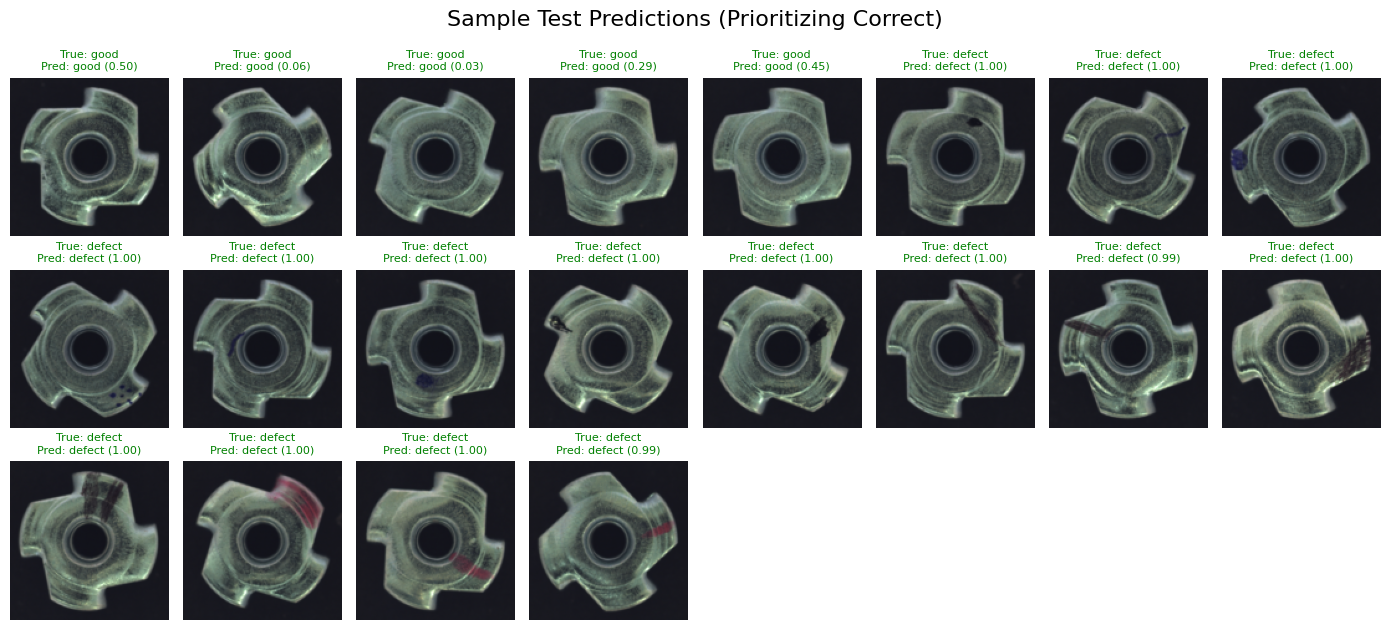

In [ ]:
import os
import json
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.datasets import ImageFolder

# assume other imports like nn, train_model, compute_metrics, display_sample_predictions,
# display_correct_predictions, summarize_and_plot, SimpleLabelImageSet, train_transform, test_transform,
# MODELS, MODELS_TO_COMPARE, DEVICE, RESULTS_DIR, TRAIN_PATH, TEST_PATH,
# defect_types, BATCH_SIZE, ATTENTION_BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY,
# EPOCHS, EARLY_STOPPING_PATIENCE, class_weights, DATASET_CATEGORY

def main():
    # Ensure results directory
    os.makedirs(RESULTS_DIR, exist_ok=True)
    print(f"Ensured results directory exists at: {RESULTS_DIR}")

    # Prepare datasets
    good_train_set = SimpleLabelImageSet(
        os.path.join(TRAIN_PATH, "good"), label=0, transform=train_transform
    )
    defect_train_sets = [
        SimpleLabelImageSet(os.path.join(TEST_PATH, d), label=1, transform=train_transform)
        for d in defect_types
    ]
    full_train_val_dataset = ConcatDataset([good_train_set] + defect_train_sets)

    good_test_set = SimpleLabelImageSet(
        os.path.join(TEST_PATH, "good"), label=0, transform=test_transform
    )
    defect_test_sets = [
        SimpleLabelImageSet(os.path.join(TEST_PATH, d), label=1, transform=test_transform)
        for d in defect_types
    ]
    test_dataset = ConcatDataset([good_test_set] + defect_test_sets)

    # Split train/validation
    train_size = int(0.8 * len(full_train_val_dataset))
    val_size = len(full_train_val_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_val_dataset, [train_size, val_size])

    print(f"\nTraining samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

    all_results = {}
    # Notification before loop
    print(f"DATASET_CATEGORY before loop: {DATASET_CATEGORY}")

    for model_name in MODELS_TO_COMPARE:
        # Initial notification
        print(f"\n{'=' * 50}")
        print(f"Preparing to train model: {model_name} on category: {DATASET_CATEGORY}")
        print(f"{'=' * 50}")
        # Debug notification inside loop
        print(f"Checking DATASET_CATEGORY value for model {model_name}: {DATASET_CATEGORY}")

        # Select batch size
        current_batch_size = (
            BATCH_SIZE if model_name != "attention" else ATTENTION_BATCH_SIZE
        )

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=current_batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=current_batch_size, shuffle=False)

        # Initialize model, optimizer, loss
        model = MODELS[model_name]().to(DEVICE)
        checkpoint_path = os.path.join(RESULTS_DIR, f"{model_name}_best.pth")
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

        # Train model
        history = train_model(
            model, train_loader, val_loader,
            loss_fn, optimizer, DEVICE,
            EPOCHS, EARLY_STOPPING_PATIENCE,
            checkpoint_path
        )

        # Load best checkpoint
        if os.path.exists(checkpoint_path):
            try:
                model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
                print(f"\nLoaded checkpoint for {model_name} from {checkpoint_path}")
            except Exception as e:
                print(f"\nError loading checkpoint for {model_name}: {e}\nProceeding with last epoch model.")
        else:
            print(f"\nNo checkpoint found for {model_name}, using last epoch model.")

        # Evaluate
        model.eval()
        all_labels, all_preds, all_probs, all_paths = [], [], [], []
        print(f"\nEvaluating {model_name} on test set...")
        with torch.no_grad():
            for inputs, labels_batch, paths in tqdm(test_loader, desc=f"{model_name} Test Eval", leave=False):
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels_batch.cpu().tolist())
                all_preds.extend(preds.cpu().tolist())
                all_probs.extend(probs[:, 1].cpu().tolist())
                all_paths.extend(paths)

        # Compute metrics and debug
        metrics = compute_metrics(all_labels, all_preds, all_probs)
        correct = sum(l == p for l, p in zip(all_labels, all_preds))
        print(f"\nDebug: {correct}/{len(all_labels)} correct → Acc: {correct/len(all_labels)*100:.2f}%")

        # Store results
        all_results[model_name] = {
            'history': history,
            'metrics': metrics,
            'predictions': {
                'labels': all_labels,
                'preds': all_preds,
                'probs': all_probs,
                'paths': all_paths
            }
        }

        # Save JSON
        results_path = os.path.join(RESULTS_DIR, f"{model_name}_results.json")
        with open(results_path, 'w') as f:
            json.dump(all_results[model_name], f, indent=2)
        print(f"\nResults for {model_name} saved to {results_path}")

        # Summarize and plot
        summarize_and_plot(
            model_name=model_name,
            history=history,
            metrics=metrics,
            all_labels=all_labels,
            results_dir=RESULTS_DIR,
            mvtec_category=DATASET_CATEGORY,
            test_dataset=test_dataset,
            model=model,
            device=DEVICE,
            num_samples=20
        )

    return all_results

if __name__ == "__main__":
    all_results = main()


Ensured results directory exists at: /content/model_comparison_results

Training samples: 250, Validation samples: 63, Test samples: 115
DATASET_CATEGORY before loop: metal_nut

Training and evaluating resnet model for category: metal_nut
DATASET_CATEGORY value before loop: metal_nut

Checking DATASET_CATEGORY value for model resnet: metal_nut
Training and evaluating resnet model for category: metal_nut


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 Training: 100%|██████████| 8/8 [00:09<00:00,  1.09s/it, loss=0.656]
                                                                           
Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, loss=0.889]
                                                                     
Epoch 2 Training: 100%|██████████| 8/8 [00:08<00:00,  1.09s/it, loss=0.493]
                                                                           
Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=2.22]
                                                                    
Epoch 3 Training: 100%|██████████| 8/8 [00:08<00:00,  1.00it/s, loss=0.146]
                                                                           
Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=4.87]
                                                                    
Epoch 4 Training: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.182]
                                                   


Early stopping triggered after 21 epochs

Loaded best checkpoint for resnet from /content/model_comparison_results/resnet_best.pth.

Evaluating resnet on the test set...



Debug: Metrics calculated using 104 correct out of 115 total test samples. Calculated Accuracy: 90.43%

Results for resnet saved to /content/model_comparison_results/resnet_results.json

resnet Model Summary:
Best Validation Accuracy: 92.06%
Test Accuracy: 90.43%
Test F1 Score: 0.9412
Test ROC AUC: 0.9150
Test Average Precision: 0.9755

Displaying sample predictions for resnet...

Running inference on all 115 test samples for display selection...


Total misclassified in test set: 11
Total correctly classified in test set: 104
Selected 20 samples for display (Prioritizing Misclassified).



Displaying sample predictions (prioritizing correct) for resnet...

Running inference on all 115 test samples for CORRECT prediction display...


Total misclassified in test set: 11
Total correctly classified in test set: 104
Selected 20 samples for display (Prioritizing Correctly Classified).


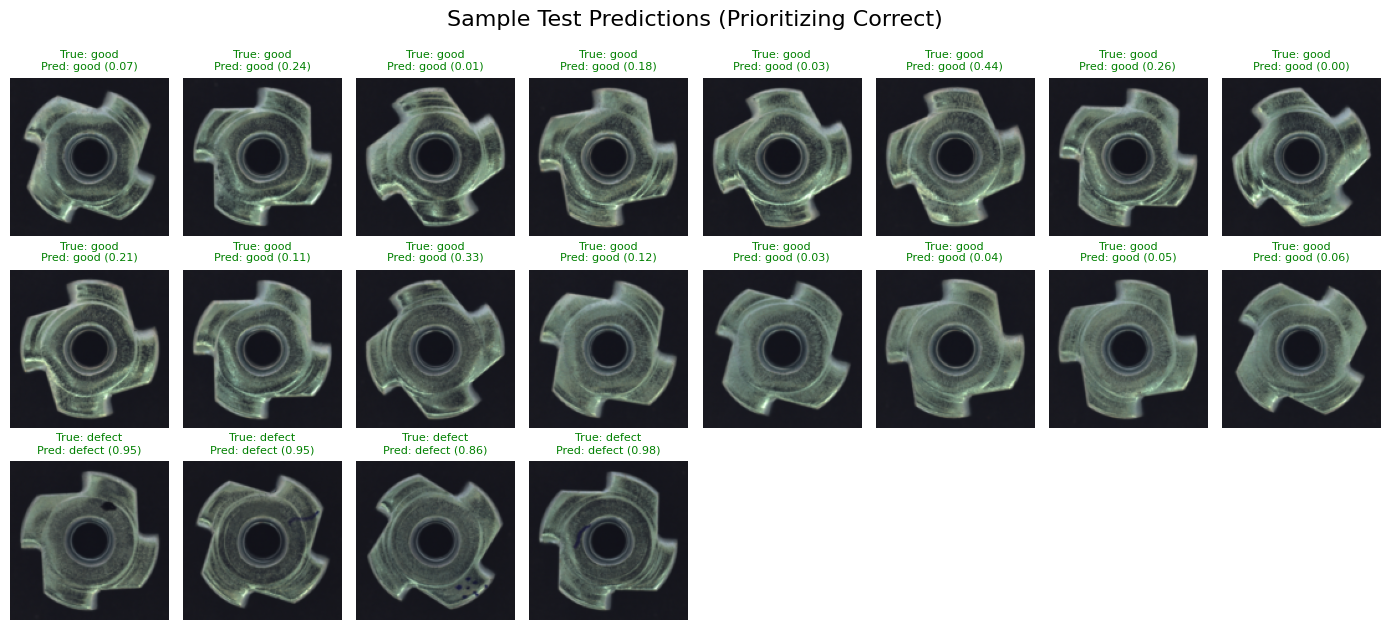


Generating Model Comparison Plots



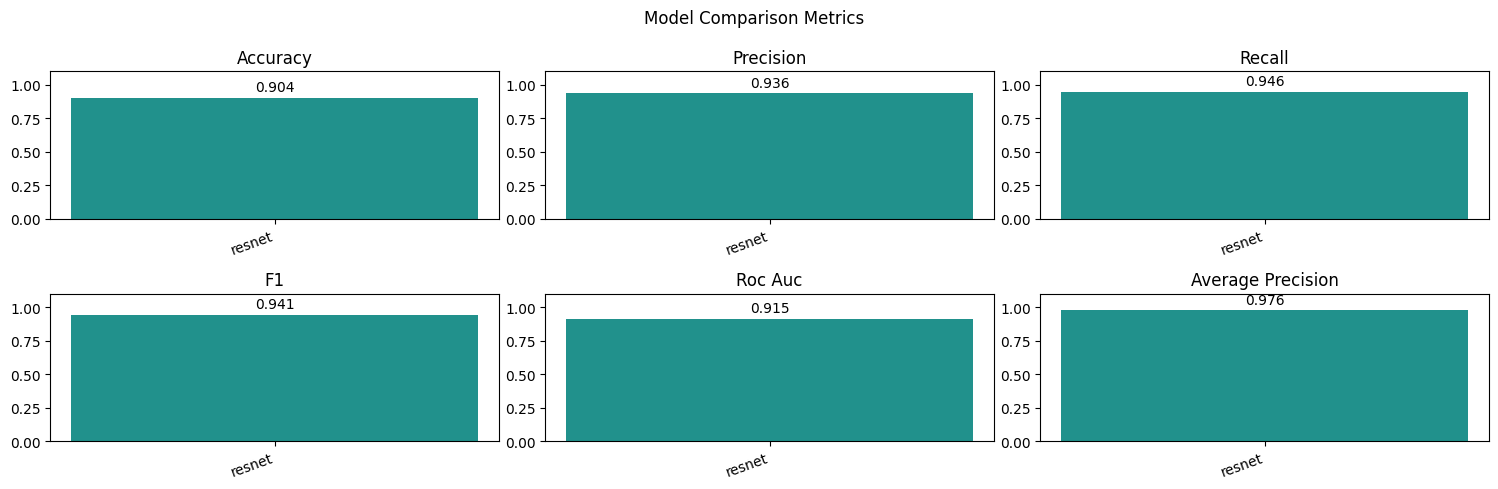

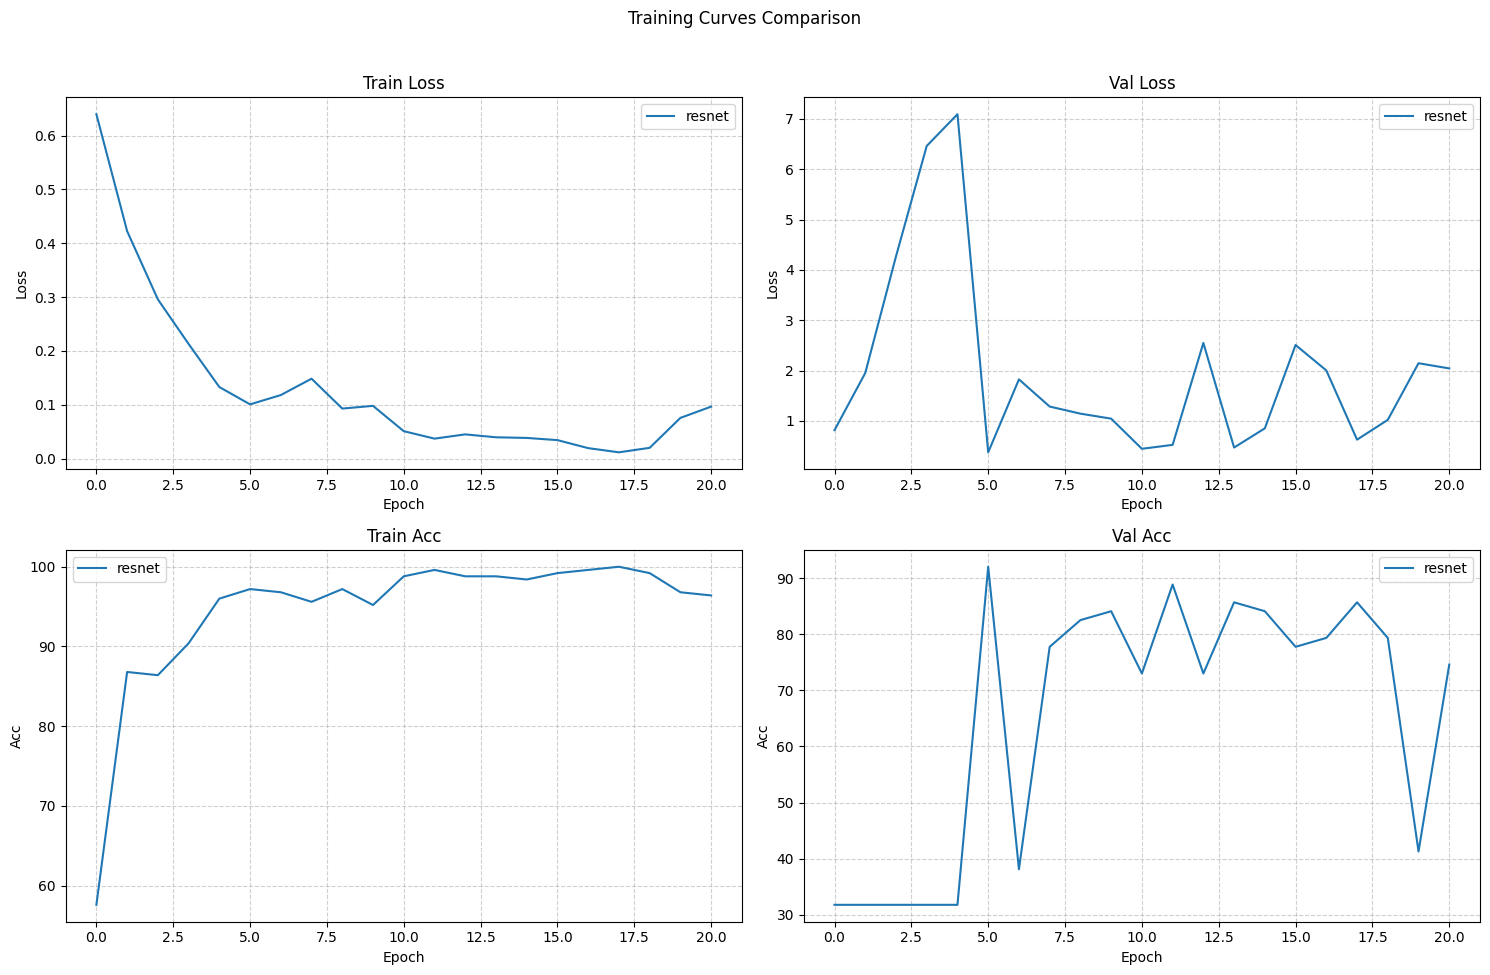

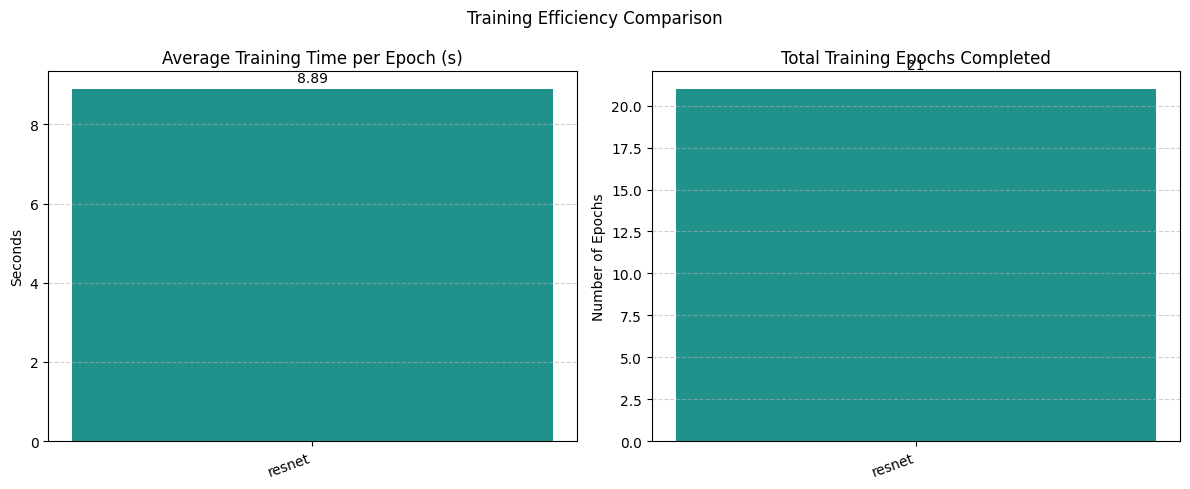


Overall model comparison results saved to /content/model_comparison_results/all_model_comparison_results.json


In [ ]:
#Manin V2
def main():
    os.makedirs(RESULTS_DIR, exist_ok=True)
    print(f"Ensured results directory exists at: {RESULTS_DIR}")
    good_train_set = SimpleLabelImageSet(os.path.join(TRAIN_PATH, "good"), label=0, transform=train_transform)
    defect_train_sets = [
        SimpleLabelImageSet(os.path.join(TEST_PATH, d), label=1, transform=train_transform)
        for d in defect_types
    ]
    full_train_val_dataset = ConcatDataset([good_train_set] + defect_train_sets)

    # Use good images from test and all defect images from test for the dedicated test dataset
    good_test_set = SimpleLabelImageSet(os.path.join(TEST_PATH, "good"), label=0, transform=test_transform)
    defect_test_sets = [
        SimpleLabelImageSet(os.path.join(TEST_PATH, d), label=1, transform=test_transform)
        for d in defect_types
    ]
    test_dataset = ConcatDataset([good_test_set] + defect_test_sets)

    # Train-validation split (80-20)
    train_size = int(0.8 * len(full_train_val_dataset))
    val_size = len(full_train_val_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_val_dataset, [train_size, val_size])

    print(f"\nTraining samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

    all_results = {}

    print(f"DATASET_CATEGORY before loop: {DATASET_CATEGORY}")

    for model_name in MODELS_TO_COMPARE:
        print(f"\n{'=' * 50}")
        print(f"Training and evaluating {model_name} model for category: {DATASET_CATEGORY}")
        print(f"{'=' * 50}")

    print(f"DATASET_CATEGORY value before loop: {DATASET_CATEGORY}")

    for model_name in MODELS_TO_COMPARE:
        print(f"\n{'=' * 50}")
        # Add this line inside the loop to check the value just before printing the header
        print(f"Checking DATASET_CATEGORY value for model {model_name}: {DATASET_CATEGORY}")
        print(f"Training and evaluating {model_name} model for category: {DATASET_CATEGORY}")
        print(f"{'=' * 50}")

        # Use smaller batch size for attention model
        current_batch_size = BATCH_SIZE if model_name != "attention" else ATTENTION_BATCH_SIZE

        # Create DataLoaders for the current model and batch size
        train_loader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=current_batch_size, shuffle=False)
        # Note: test_loader batch size also set to current_batch_size for consistency in eval
        test_loader = DataLoader(test_dataset, batch_size=current_batch_size, shuffle=False)

        # Initialize model
        model = MODELS[model_name]().to(DEVICE)
        checkpoint_path = os.path.join(RESULTS_DIR, f"{model_name}_best.pth")

        # Loss function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

        # Train the model
        history = train_model(model, train_loader, val_loader, loss_fn, optimizer, DEVICE, EPOCHS, EARLY_STOPPING_PATIENCE, checkpoint_path)

        # Load best model for evaluation
        if os.path.exists(checkpoint_path):
            try:
                model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
                print(f"\nLoaded best checkpoint for {model_name} from {checkpoint_path}.")
            except Exception as e:
                print(f"\nError loading checkpoint for {model_name}: {e}")
                print("Proceeding with the model from the last trained epoch.")
        else:
            print(f"\nNo checkpoint found at {checkpoint_path}. Using model from the last trained epoch.")

        # Evaluate on the test set
        model.eval()
        all_labels = []
        all_preds = []
        all_probs = []
        all_paths = [] # Collect paths for visualization

        print(f"\nEvaluating {model_name} on the test set...")
        with torch.no_grad():
            test_eval_iterator = tqdm(test_loader, desc=f"{model_name} Test Evaluation", leave=False)
            for inputs, labels, paths in test_eval_iterator:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                # Use softmax from torch.nn.functional
                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

                all_labels.extend(labels.cpu().numpy().astype(int).tolist())
                all_preds.extend(preds.cpu().numpy().astype(int).tolist())
                all_probs.extend(probs[:, 1].cpu().numpy().astype(float).tolist())
                all_paths.extend(paths)

        # Compute and store metrics
        metrics = compute_metrics(all_labels, all_preds, all_probs)

        # Debug: Print counts for accuracy check
        correctly_classified_count = sum(1 for i in range(len(all_labels)) if all_labels[i] == all_preds[i])
        total_test_count = len(all_labels)
        print(f"\nDebug: Metrics calculated using {correctly_classified_count} correct out of {total_test_count} total test samples. Calculated Accuracy: {(correctly_classified_count / total_test_count * 100):.2f}%")

        all_results[model_name] = {
            'history': history,
            'metrics': metrics,
            'predictions': {
                'labels': all_labels,
                'preds': all_preds,
                'probs': all_probs,
                'paths': all_paths # Store paths
            }
        }

        # Save results for this model
        model_results_path = os.path.join(RESULTS_DIR, f"{model_name}_results.json")
        with open(model_results_path, 'w') as f:
            json.dump(all_results[model_name], f, indent=2)
        print(f"\nResults for {model_name} saved to {model_results_path}")

        # Print summary metrics
        print(f"\n{model_name} Model Summary:")
        if history['val_acc']: # Check if history is not empty (training might have skipped if no epochs)
            print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
        print(f"Test Accuracy: {metrics['accuracy']*100:.2f}%")
        print(f"Test F1 Score: {metrics['f1']:.4f}")
        if metrics['roc_auc'] is not None:
            print(f"Test ROC AUC: {metrics['roc_auc']:.4f}")
        if metrics['average_precision'] is not None:
            print(f"Test Average Precision: {metrics['average_precision']:.4f}")

        # Display sample predictions for the current model
        print(f"\nDisplaying sample predictions for {model_name}...")
        display_sample_predictions(model, test_dataset, DEVICE, num_samples=20) # Display 20 samples

        # Display sample predictions for the current model (prioritizing correct)
        print(f"\nDisplaying sample predictions (prioritizing correct) for {model_name}...")
        display_correct_predictions(model, test_dataset, DEVICE, num_samples=20) # Display 20 samples

    # Plot comparison charts after all models are evaluated
    if all_results:
        print("\n" + "="*50)
        print("Generating Model Comparison Plots")
        print("="*50 + "\n")
        plot_model_comparison(all_results)

        # Save all results to a single JSON file
        final_results_path = os.path.join(RESULTS_DIR, "all_model_comparison_results.json")
        with open(final_results_path, 'w') as f:
            json.dump(all_results, f, indent=2)
        print(f"\nOverall model comparison results saved to {final_results_path}")
    else:
        print("\nNo models were run for comparison.")

    return all_results

if __name__ == "__main__":
    # Run the main function to train and evaluate models and collect results
    all_results = main()

# EOF
